# Steady-State Model Identification

## Imports

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import tclab


## Experimental Inputs

In [4]:
# enter (U1, U2) test points

U = [
    (60, 60),
    (20, 20),
    (100, 20),
    (20, 100),
    (100, 100),
]

# how long to wait for steady state
t_ss = 800

# how long to take measurements
t_meas = 60

# sample time
t_sample = 5

In [5]:
for U1, U2 in U:
    print(U1, U2)

60 60
20 20
100 20
20 100
100 100


## Perform Experiment

TCLab version 0.4.9
Simulated TCLab


<IPython.core.display.Javascript object>


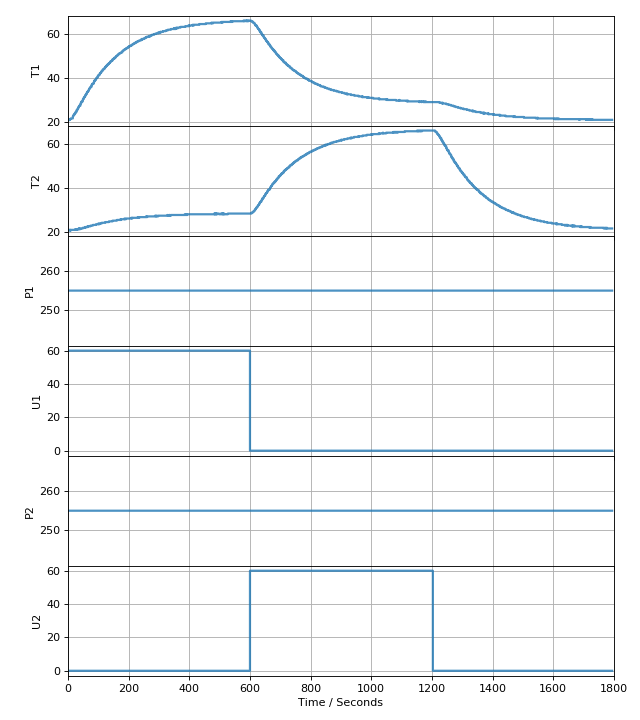

TCLab Model disconnected successfully.


In [42]:
for U1, U2 in U:
    with TCLab() as lab:
    sources = [
        ('T1', lambda: lab.T1),
        ('T2', lambda: lab.T2),
        ('P1', lambda: lab.P1),
        ('U1', lambda: lab.U1),
        ('P2', lambda: lab.P2),
        ('U2', lambda: lab.U2),
    ]
    h = Historian(sources)
    p = Plotter(h, tperiod)
    lab.P1 = 200
    lab.P2 = 200
    lab.U1 = U1
    lab.U2 = U2
    for t in clock(t_ss, tsample)
        p.update(t)
    h.to_csv('data{0}{1}.csv'.format(U1, U2))

## Fit Model to Data

In [43]:
# read data file

import pandas as pd

data = pd.read_csv('data.csv').set_index('Time')[1:]
t = data.index
T1 = data['T1'].values
T2 = data['T2'].values
P1 = data['P1'].values
P2 = data['P2'].values
U1 = data['U1'].values
U2 = data['U2'].values

# known parameter values
T_ambient = (T1[0] + T2[0])/2.0
T_ambient

P1 = 0.013*P1.mean()
P2 = 0.013*P2.mean()

<IPython.core.display.Javascript object>


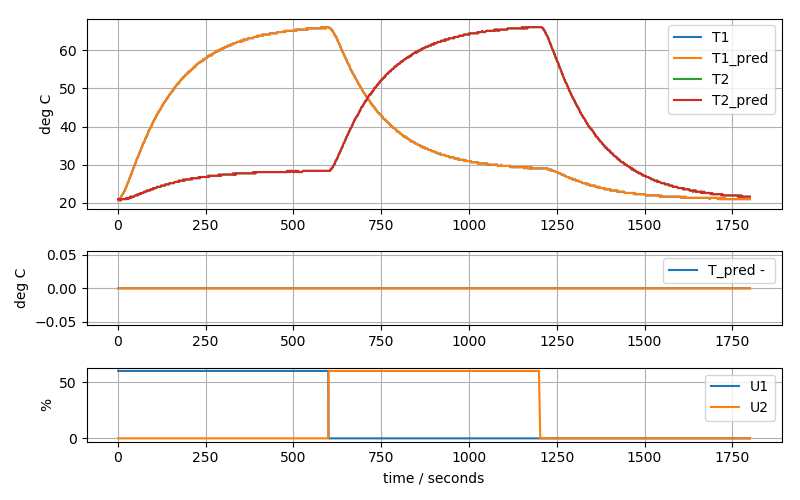

In [44]:
# data plotting function

def plot_data(t, T1, T1_pred, T2, T2_pred, U1, U2):
    
    fig = plt.figure(figsize=(8,5))
    grid = plt.GridSpec(4, 1)
    ax = [fig.add_subplot(grid[:2]), fig.add_subplot(grid[2]), fig.add_subplot(grid[3])]

    ax[0].plot(t, T1, t, T1_pred, t, T2, t, T2_pred)
    ax[0].set_ylabel("deg C")
    ax[0].legend(["T1", "T1_pred", "T2", "T2_pred"])
    
    ax[1].plot(t, T1_pred - T1, t, T2_pred - T2)
    ax[1].set_ylabel("deg C")
    ax[1].legend(["T_pred - "])
    
    ax[2].plot(t, U1, t, U2)
    ax[2].set_ylabel("%")
    ax[2].legend(["U1", "U2"])
    
    for a in ax: a.grid(True)
    ax[-1].set_xlabel("time / seconds")
    plt.tight_layout()
    
plot_data(t, T1, T1, T2, T2, U1, U2)

In [58]:
from ipywidgets import interact
from scipy.integrate import odeint
from scipy.optimize import minimize

def compare(Ua, Ub, Uc, Cp_H, Cp_S):
    model_complete([Ua, Ub, Uc, Cp_H, Cp_S], True)

def model_complete(param, plot=False):
    
    Ua, Ub, Uc, Cp_H, Cp_S = param

    def deriv(T, t):
        T_H1, T_S1, T_H2, T_S2 = T
        dT_H1 = -(Ua + Ub + Uc)*T_H1/Cp_H + Ub*T_H2/Cp_H + Uc*T_S1/Cp_H + P1*u1(t)/Cp_H/100
        dT_S1 = Uc*T_H1/Cp_S - Uc*T_S1/Cp_S
        dT_H2 = -(Ua + Ub + Uc)*T_H2/Cp_H + Ub*T_H1/Cp_H + Uc*T_S2/Cp_H + P2*u2(t)/Cp_H/100
        dT_S2 = Uc*T_H2/Cp_S - Uc*T_S2/Cp_S
        return [dT_H1, dT_S1, dT_H2, dT_S2]
    
    T = odeint(deriv, [0,0,0,0], t)
    
    T1_pred = T[:,1] + T_ambient
    T2_pred = T[:,3] + T_ambient
    
    print(param)
    if plot:
        plot_data(t, T1, T1_pred, T2, T2_pred, U1, U2)
        
    return np.linalg.norm(T[:,1] - T1 + T_ambient) + np.linalg.norm(T[:,3] - T2 + T_ambient)

# parameter values and units
Ua = 0.036             # watts/deg C
Ub = 0.01            # watts/deg C
Uc = 0.08
Cp_H = 4.9                # joules/deg C
Cp_S = 1.26


w = interact(compare, 
             Ua=(0, 2*Ua, 0.001), 
             Ub=(0, 2*Ub, 0.001), 
             Uc=(0, 2*Uc, 0.001), 
             Cp_H=(0, 2*Cp_H, 0.01), 
             Cp_S = (0, 2*Cp_S, .01))

interactive(children=(FloatSlider(value=0.036000000000000004, description='Ua', max=0.072, step=0.001), FloatS…